# Pre

In [1]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator

/home/hchuang/anaconda3/envs/lag-llama/lib/python3.10/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [2]:
import numpy as np
import pandas as pd

In [3]:
import sys
from types import ModuleType

# Create dummy module hierarchy
def create_dummy_module(module_path):
    """
    Create a dummy module hierarchy for the given path.
    Returns the leaf module.
    """
    parts = module_path.split('.')
    current = ''
    parent = None

    for part in parts:
        current = current + '.' + part if current else part
        if current not in sys.modules:
            module = ModuleType(current)
            sys.modules[current] = module
            if parent:
                setattr(sys.modules[parent], part, module)
        parent = current

    return sys.modules[module_path]

# Create the dummy gluonts module hierarchy
gluonts_module = create_dummy_module('gluonts.torch.modules.loss')

# Create dummy classes for the specific loss functions
class DistributionLoss:
    def __init__(self, *args, **kwargs):
        pass

    def __call__(self, *args, **kwargs):
        return 0.0

    def __getattr__(self, name):
        return lambda *args, **kwargs: None

class NegativeLogLikelihood:
    def __init__(self, *args, **kwargs):
        pass

    def __call__(self, *args, **kwargs):
        return 0.0

    def __getattr__(self, name):
        return lambda *args, **kwargs: None

# Add the specific classes to the module
gluonts_module.DistributionLoss = DistributionLoss
gluonts_module.NegativeLogLikelihood = NegativeLogLikelihood

## Lag-Llama prediciton function

In [145]:
def get_lag_llama_predictions(dataset, prediction_length, device, context_length=32, use_rope_scaling=False, num_samples=100):
    ckpt = torch.load("lag-llama.ckpt", map_location=device, weights_only = False) # Uses GPU since in this Colab we use a GPU.
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length, # Lag-Llama was trained with a context length of 32, but can work with any context length

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,

        batch_size=1,
        num_parallel_samples=100,
        device=device,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

# NYISO dataset

In [142]:
sys.path.append("/home/hchuang/Documents/Project/Package/my_dataset")
from my_dataset.datasets.load_data import load_datasets
data_dict = load_datasets('NYISO-N.Y.C.')
data_dict.keys()

dict_keys(['N.Y.C._train_stdd.npy', 'N.Y.C._test.npy', 'N.Y.C._test_stdd.npy', 'N.Y.C._day_of_week_test.npy', 'N.Y.C._train.npy', 'N.Y.C._day_of_week_train.npy'])

In [143]:
test_nyc_npy = np.squeeze(data_dict['N.Y.C._test.npy']) # reduce useless dimension ((73, 92, 1) -> (73, 92))
df_wide = pd.DataFrame(test_nyc_npy).T # (192,73)
print(df_wide.shape)

(192, 73)


# Zero-shot

In [146]:
# Pre-process

# (new)Generate a DatetimeIndex for PandasDataset(dict(df_wide))
dt_index = pd.date_range(start="2024-01-01", periods=192, freq="H")
df_wide.index = dt_index

# Convert numerical columns to float 32 format for lag-llama
for col in df_wide.columns:
    # Check if column is not of string type
    if df_wide[col].dtype != 'object' and pd.api.types.is_string_dtype(df_wide[col]) == False:
        df_wide[col] = df_wide[col].astype('float32')

# Create a PandasDataset
ds = PandasDataset(dict(df_wide))

# Prediction

backtest_dataset = ds
prediction_length = 24  # Define your prediction length (e.g., 24 here since the data frequency is hourly).
num_samples = 100 # number of samples sampled from the probability distribution for each timestep
device = torch.device("cuda:0") # You can switch this to CPU or other GPUs if you'd like, depending on your environment


forecasts, tss = get_lag_llama_predictions(backtest_dataset, prediction_length, device, num_samples = num_samples) # (new) note that num_samples is optional argu, need to specify

d = forecasts[0].samples
d.shape

/tmp/ipykernel_48806/4186143968.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dt_index = pd.date_range(start="2024-01-01", periods=192, freq="H")


(100, 24)

In [8]:
# Evaluation
actual = test_nyc_npy[:,-24:]
pred = np.array([np.mean(forecasts[i].samples,axis=0) for i in range(len(forecasts))])

mape = np.mean(abs((pred - actual)/actual))*100

print(f"MAPE: {round(mape,4)}")


MAPE: 14.3293


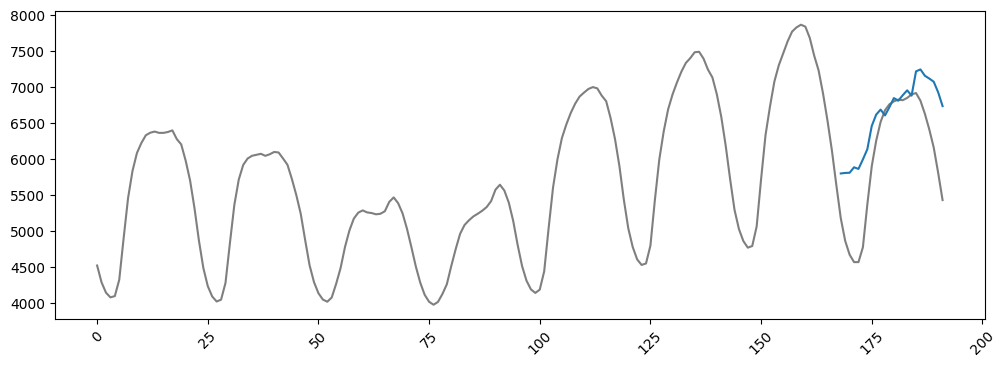

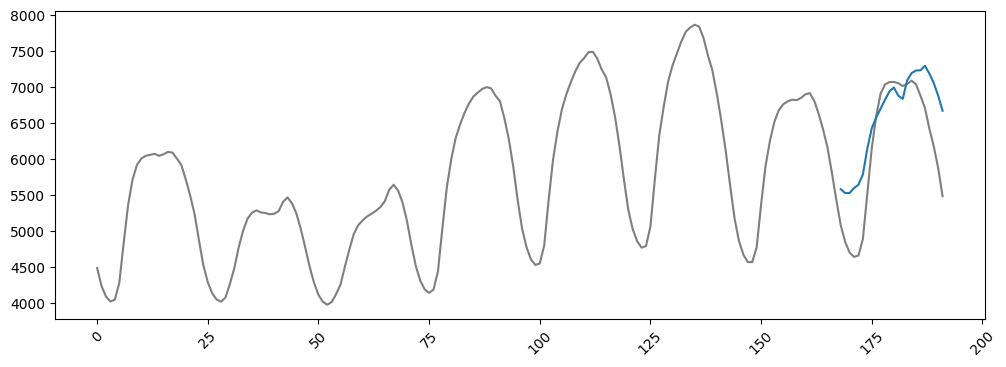

In [9]:
for obs in range(2):
    x = range(0,192)
    y = test_nyc_npy[obs,:]
    x_pred = range(168, 192)
    y_pred = pred[obs,:]


    plt.figure(figsize=(12, 4)) 
    plt.plot(x, y, color = 'tab:gray')
    plt.plot(x_pred, y_pred, color = 'tab:blue')
    #plt.title(f'{zone_name[zone_index]}: MAPE = {round(mape_all[obs],2)} , MSE = {round(mse_all[obs]*1,2)}')
    plt.xticks(rotation=45) 
    plt.show()

# Issue:資料有沒有錯誤

In [119]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from tqdm import tqdm
from itertools import islice

from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset
from lag_llama.gluon.estimator import LagLlamaEstimator

# 房地產交易量資料
df = pd.DataFrame({
    'Taipei': [1526.0, 1566.0, 2118.0, 1884.0, 2730.0, 1670.0, 1347.0, 2442.0, 2705.0, 2855.0, 2518.0, 2133.0, 1999.0, 2169.0, 2277.0, 2239.0, 2967.0, 1604.0, 1206.0, 2101.0, 2405.0, 1780.0, 1596.0, 1755.0, 1473.0, 1551.0, 1741.0, 1709.0, 2291.0, 1176.0, 768.0, 1488.0, 1502.0, 1390.0, 1304.0, 1345.0, 1175.0, 1311.0, 1554.0, 1885.0, 2038.0, 868.0, 509.0, 1062.0, 1479.0, 1769.0, 1355.0, 1263.0, 1211.0, 1085.0, 1187.0, 1305.0, 1467.0, 1013.0, 988.0, 1466.0, 1408.0, 1397.0, 1390.0, 1395.0, 1397.0, 1240.0, 1461.0, 1929.0, 1589.0, 1463.0, 843.0, 1691.0, 1616.0, 1700.0, 1622.0, 1618.0, 1516.0, 1383.0, 1586.0, 1450.0, 1613.0, 1535.0, 920.0, 1835.0, 1816.0, 1847.0, 1917.0, 1921.0, 1558.0, 1740.0, 1782.0, 1841.0, 2034.0, 1311.0, 1438.0, 1640.0, 1485.0, 1908.0, 2167.0, 2444.0, 2246.0, 2037.0, 2068.0, 2115.0, 2305.0, 1869.0, 1315.0, 2272.0, 2285.0, 1624.0, 1057.0, 1528.0, 1754.0, 1870.0, 2023.0, 2134.0, 2007.0, 1611.0, 1238.0, 2016.0, 1624.0, 1345.0, 1461.0, 1492.0, 1298.0, 1366.0, 1328.0, 1369.0, 1542.0],
    'New Taipei': [3848.0, 4887.0, 5786.0, 4166.0, 5382.0, 3679.0, 2757.0, 5764.0, 5790.0, 5963.0, 5621.0, 6319.0, 5156.0, 5300.0, 6160.0, 6194.0, 5960.0, 2753.0, 2565.0, 4523.0, 4450.0, 4493.0, 3645.0, 4113.0, 3521.0, 3725.0, 4019.0, 4233.0, 4662.0, 2543.0, 1956.0, 3600.0, 3332.0, 3100.0, 3417.0, 3172.0, 2681.0, 2544.0, 3064.0, 3779.0, 3693.0, 1856.0, 1147.0, 2470.0, 2760.0, 3241.0, 2959.0, 3249.0, 3014.0, 2689.0, 3077.0, 3202.0, 4230.0, 2063.0, 2170.0, 3318.0, 3753.0, 3998.0, 3661.0, 3380.0, 3249.0, 3381.0, 3615.0, 3794.0, 4036.0, 3326.0, 2034.0, 4083.0, 3679.0, 4258.0, 3853.0, 3775.0, 3950.0, 3804.0, 4150.0, 3701.0, 3905.0, 3880.0, 2416.0, 4396.0, 4408.0, 4468.0, 4476.0, 4579.0, 3910.0, 4348.0, 4681.0, 4593.0, 4615.0, 3005.0, 3604.0, 4224.0, 3665.0, 5187.0, 5678.0, 5838.0, 5718.0, 5322.0, 5449.0, 5257.0, 4790.0, 4302.0, 3136.0, 5832.0, 5456.0, 3819.0, 2110.0, 3618.0, 4643.0, 4773.0, 5421.0, 4880.0, 4881.0, 3608.0, 2898.0, 4844.0, 4006.0, 3199.0, 3172.0, 3340.0, 2914.0, 2943.0, 2898.0, 2821.0, 3128.0],
    'Taoyuan': [2341.0, 2499.0, 3006.0, 3288.0, 3471.0, 2832.0, 1923.0, 4424.0, 4581.0, 4262.0, 3698.0, 3821.0, 4188.0, 4085.0, 3267.0, 3319.0, 4290.0, 1961.0, 2126.0, 3558.0, 3342.0, 3773.0, 2582.0, 2364.0, 2354.0, 2521.0, 2917.0, 2994.0, 2998.0, 1762.0, 1158.0, 2075.0, 2677.0, 2500.0, 2128.0, 2039.0, 1742.0, 1929.0, 2076.0, 3162.0, 2531.0, 1377.0, 863.0, 3069.0, 2401.0, 3736.0, 2462.0, 2476.0, 2051.0, 2326.0, 2533.0, 2472.0, 2354.0, 1431.0, 1808.0, 2575.0, 2536.0, 2477.0, 2597.0, 2454.0, 2327.0, 2116.0, 2430.0, 2552.0, 2464.0, 2420.0, 1261.0, 2577.0, 2666.0, 2731.0, 2886.0, 2914.0, 2778.0, 2582.0, 2890.0, 2472.0, 2512.0, 2499.0, 1604.0, 3484.0, 3350.0, 3448.0, 3438.0, 3514.0, 3093.0, 3386.0, 3812.0, 3721.0, 3331.0, 2347.0, 2716.0, 3553.0, 3080.0, 3841.0, 4063.0, 4318.0, 4247.0, 4117.0, 4211.0, 4146.0, 3834.0, 3165.0, 2065.0, 4056.0, 4261.0, 3248.0, 2114.0, 2811.0, 3408.0, 3935.0, 4122.0, 4069.0, 3743.0, 2804.0, 2089.0, 3769.0, 2995.0, 2424.0, 2196.0, 2424.0, 2098.0, 2248.0, 2191.0, 1914.0, 1929.0],
    'Taichung': [2683.0, 3174.0, 3660.0, 3104.0, 3933.0, 3011.0, 2342.0, 4094.0, 3888.0, 4087.0, 3852.0, 3789.0, 4089.0, 3586.0, 4138.0, 3871.0, 4363.0, 2676.0, 2572.0, 4058.0, 3826.0, 3011.0, 3477.0, 2980.0, 2715.0, 2929.0, 3141.0, 3617.0, 3658.0, 2869.0, 1513.0, 2587.0, 2699.0, 2580.0, 2446.0, 2435.0, 2069.0, 1731.0, 2147.0, 2825.0, 2705.0, 1624.0, 1132.0, 2312.0, 2456.0, 2466.0, 2369.0, 2387.0, 2102.0, 2463.0, 2327.0, 2240.0, 2693.0, 2333.0, 1896.0, 2780.0, 2966.0, 3313.0, 2844.0, 2847.0, 3036.0, 2615.0, 3218.0, 3284.0, 3362.0, 3160.0, 1815.0, 3375.0, 3406.0, 3358.0, 3152.0, 3241.0, 2943.0, 3221.0, 3309.0, 3180.0, 3451.0, 3423.0, 2248.0, 4221.0, 4107.0, 4052.0, 4242.0, 4341.0, 3706.0, 4375.0, 4492.0, 4523.0, 4290.0, 2774.0, 3574.0, 4030.0, 3182.0, 4120.0, 4466.0, 4802.0, 4962.0, 4929.0, 5131.0, 4770.0, 4359.0, 4111.0, 2688.0, 4381.0, 3855.0, 3184.0, 1961.0, 2846.0, 3130.0, 3847.0, 3783.0, 3527.0, 3379.0, 2736.0, 2096.0, 3405.0, 2881.0, 2434.0, 2203.0, 2216.0, 1971.0, 2122.0, 2123.0, 1972.0, 2055.0],
    'Tainan': [1097.0, 1220.0, 1584.0, 1757.0, 1909.0, 1409.0, 1071.0, 2021.0, 1844.0, 1774.0, 1817.0, 1617.0, 1423.0, 1506.0, 1577.0, 1701.0, 2083.0, 947.0, 1114.0, 1700.0, 1653.0, 1633.0, 1663.0, 1498.0, 1260.0, 1497.0, 1375.0, 1405.0, 2038.0, 1250.0, 809.0, 1486.0, 1418.0, 1348.0, 1381.0, 1288.0, 1102.0, 1187.0, 1311.0, 1540.0, 2362.0, 973.0, 622.0, 1239.0, 1247.0, 1308.0, 1639.0, 1101.0, 1104.0, 1092.0, 1389.0, 1266.0, 1907.0, 905.0, 952.0, 1738.0, 1403.0, 1393.0, 1440.0, 1430.0, 1576.0, 1385.0, 1554.0, 1638.0, 2120.0, 1771.0, 1138.0, 2022.0, 1913.0, 1939.0, 1662.0, 1605.0, 1524.0, 1413.0, 1545.0, 1564.0, 1689.0, 1672.0, 1254.0, 2098.0, 2126.0, 2249.0, 1811.0, 1982.0, 1612.0, 1928.0, 2153.0, 2168.0, 2282.0, 1473.0, 1869.0, 1963.0, 1531.0, 2175.0, 2330.0, 3003.0, 2583.0, 2608.0, 3124.0, 2869.0, 2322.0, 1963.0, 1446.0, 2286.0, 2098.0, 1838.0, 1452.0, 1527.0, 1628.0, 1879.0, 1858.0, 1796.0, 1757.0, 1500.0, 1095.0, 1711.0, 1422.0, 1349.0, 1095.0, 1105.0, 1020.0, 1094.0, 999.0, 920.0, 1115.0],
    'Kaohsiung': [2003.0, 2464.0, 2748.0, 2597.0, 3017.0, 2487.0, 1878.0, 3332.0, 3516.0, 3379.0, 3109.0, 3117.0, 2673.0, 2550.0, 2913.0, 2582.0, 3890.0, 2413.0, 1882.0, 2844.0, 2859.0, 2776.0, 2783.0, 2392.0, 1902.0, 2226.0, 2472.0, 2397.0, 3168.0, 1758.0, 1302.0, 2440.0, 2297.0, 2226.0, 2223.0, 2310.0, 1900.0, 1893.0, 2090.0, 2707.0, 3198.0, 1398.0, 990.0, 1884.0, 2356.0, 2473.0, 2413.0, 2289.0, 2019.0, 1925.0, 2457.0, 2503.0, 2638.0, 1567.0, 1892.0, 2753.0, 2578.0, 2411.0, 2657.0, 2326.0, 2324.0, 2124.0, 2300.0, 2752.0, 2640.0, 2574.0, 1609.0, 2810.0, 2644.0, 2819.0, 2520.0, 2663.0, 2380.0, 2311.0, 2797.0, 2341.0, 3321.0, 2983.0, 2229.0, 3713.0, 3418.0, 3122.0, 2738.0, 3069.0, 2665.0, 3033.0, 3096.0, 2998.0, 3095.0, 2302.0, 2659.0, 2915.0, 2611.0, 3331.0, 3543.0, 3841.0, 3395.0, 3528.0, 3695.0, 3692.0, 3313.0, 3268.0, 2359.0, 3940.0, 3462.0, 2795.0, 2093.0, 2912.0, 3137.0, 4659.0, 4161.0, 3726.0, 3451.0, 2574.0, 2186.0, 2917.0, 2650.0, 2181.0, 1987.0, 2058.0, 1806.0, 2028.0, 1919.0, 1661.0, 1826.0],
})

counties = ['Taipei', 'New Taipei', 'Taoyuan', 'Taichung', 'Tainan', 'Kaohsiung']

In [121]:
df.shape

(125, 6)

In [130]:
from gluonts.dataset.common import ListDataset

# 訓練資料
population_data = [
    {
        'start': pd.Timestamp('2012-08-01', unit='M'),
        'target': df.iloc[:-24, :][county].to_list(), # 原始資料減兩年
    } for county in counties
]
dataset_train = ListDataset(
    data_iter=population_data,
    freq="1M"
)

# 測試資料
population_data = [
    {
        'start': pd.Timestamp('2012-08-01', unit='M'),
        'target': df[county].to_list(), # 原始資料
    } for county in counties
]
dataset_test = ListDataset(
    data_iter=population_data,
    freq="1M"
)

/home/hchuang/anaconda3/envs/lag-llama/lib/python3.10/site-packages/gluonts/dataset/common.py:255: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ProcessDataEntry(to_offset(freq), one_dim_target, use_timestamp),


In [131]:
dataset_train[0]

{'start': Period('2012-08', 'M'),
 'target': array([1526., 1566., 2118., 1884., 2730., 1670., 1347., 2442., 2705.,
        2855., 2518., 2133., 1999., 2169., 2277., 2239., 2967., 1604.,
        1206., 2101., 2405., 1780., 1596., 1755., 1473., 1551., 1741.,
        1709., 2291., 1176.,  768., 1488., 1502., 1390., 1304., 1345.,
        1175., 1311., 1554., 1885., 2038.,  868.,  509., 1062., 1479.,
        1769., 1355., 1263., 1211., 1085., 1187., 1305., 1467., 1013.,
         988., 1466., 1408., 1397., 1390., 1395., 1397., 1240., 1461.,
        1929., 1589., 1463.,  843., 1691., 1616., 1700., 1622., 1618.,
        1516., 1383., 1586., 1450., 1613., 1535.,  920., 1835., 1816.,
        1847., 1917., 1921., 1558., 1740., 1782., 1841., 2034., 1311.,
        1438., 1640., 1485., 1908., 2167., 2444., 2246., 2037., 2068.,
        2115., 2305.], dtype=float32)}

# Fine-tune

In [81]:
from gluonts.dataset.common import ListDataset
from pandas import Timestamp

In [82]:
# 設定起始時間，這裡假設是 2020-01-01，你可以根據實際情況修改
start_date = "2020-01-01"

train_nyc_npy = np.squeeze(data_dict['N.Y.C._train.npy']) # reduce useless dimension ((?, 192, 1) -> (?, 192))
data_train = pd.DataFrame(train_nyc_npy).T # (192,?)
data_train = np.array(data_train)

# 轉換成 GluonTS ListDataset
dataset_train = ListDataset(
    [
        {
            "start": start_date,  # 這裡假設是每日數據
            "target": data_train[:, i].tolist()  # 提取第 i 條序列
        }
        for i in range(data_train.shape[1])  # 遍歷 4121 條序列
    ],
    freq="H",  # 時間頻率
)


test_nyc_npy = np.squeeze(data_dict['N.Y.C._test.npy']) # reduce useless dimension ((?, 192, 1) -> (?, 192))
data_test = pd.DataFrame(test_nyc_npy).T # (192,?)
data_test = np.array(data_test)

# 轉換成 GluonTS ListDataset
dataset_test = ListDataset(
    [
        {
            "start": start_date,  # 這裡假設是每日數據
            "target": data_test[:, i].tolist()  # 提取第 i 條序列
        }
        for i in range(data_test.shape[1])  # 遍歷 4121 條序列
    ],
    freq="H",  # 修改為你的時間頻率
)


/home/hchuang/anaconda3/envs/lag-llama/lib/python3.10/site-packages/gluonts/dataset/common.py:255: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ProcessDataEntry(to_offset(freq), one_dim_target, use_timestamp),
/home/hchuang/anaconda3/envs/lag-llama/lib/python3.10/site-packages/gluonts/dataset/common.py:255: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ProcessDataEntry(to_offset(freq), one_dim_target, use_timestamp),


In [132]:
prediction_length = 24
context_length = 168
device = torch.device("cuda:0") # You can switch this to CPU or other GPUs if you'd like, depending on your environment
num_samples = 100


In [133]:
import torch
ckpt = torch.load("lag-llama.ckpt", map_location=device, weights_only = False)

if "state_dict" in ckpt:
    state_dict = ckpt["state_dict"]
elif "model" in ckpt:  # 有些 ckpt 可能存儲在 "model" 鍵下
    state_dict = ckpt["model"]
else:
    state_dict = ckpt  # 若沒有明確的 state_dict，可能直接是模型參數

# 計算總參數數量
total_params = sum(p.numel() for p in state_dict.values())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 2,449,299


In [134]:
ckpt = torch.load("lag-llama.ckpt", map_location=device, weights_only = False)
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,

        # distr_output="neg_bin",
        scaling="mean",
        nonnegative_pred_samples=True,
        aug_prob=0,
        lr=1e-2,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        time_feat=estimator_args["time_feat"],

        # rope_scaling={
        #     "type": "linear",
        #     "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        # },
        
        batch_size=64,
        num_parallel_samples=num_samples,
        trainer_kwargs = {"max_epochs": 15,}, # <- lightning trainer arguments



        # use_cosine_annealing_lr = True,
        # cosine_annealing_lr_args = {
        #     "T_max": 5,
        #     "eta_min": 0
        #     }

    )

In [135]:
predictor = estimator.train(training_data = dataset_train, cache_data=True, shuffle_buffer_length=1000)
# train(training_data: Dataset, validation_data: Optional[Dataset] = None, shuffle_buffer_length: Optional[int] = None, cache_data: bool = False, ckpt_path: Optional[str] = None, **kwargs)
# PyTorchLightningEstimator https://ts.gluon.ai/dev/api/gluonts/gluonts.torch.model.estimator.html

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/hchuang/anaconda3/envs/lag-llama/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4

Epoch 0: |          | 50/? [00:04<00:00, 11.35it/s, v_num=7]

Epoch 0, global step 50: 'train_loss' reached 9.98888 (best 9.98888), saving model to '/home/hchuang/Documents/Project/lag-llama/lightning_logs/version_7/checkpoints/epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:03<00:00, 12.98it/s, v_num=7]

Epoch 1, global step 100: 'train_loss' reached 8.81380 (best 8.81380), saving model to '/home/hchuang/Documents/Project/lag-llama/lightning_logs/version_7/checkpoints/epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:03<00:00, 14.35it/s, v_num=7]

Epoch 2, global step 150: 'train_loss' was not in top 1


Epoch 3: |          | 50/? [00:03<00:00, 14.30it/s, v_num=7]

Epoch 3, global step 200: 'train_loss' reached 8.79732 (best 8.79732), saving model to '/home/hchuang/Documents/Project/lag-llama/lightning_logs/version_7/checkpoints/epoch=3-step=200.ckpt' as top 1


Epoch 4: |          | 50/? [00:03<00:00, 14.44it/s, v_num=7]

Epoch 4, global step 250: 'train_loss' reached 8.08397 (best 8.08397), saving model to '/home/hchuang/Documents/Project/lag-llama/lightning_logs/version_7/checkpoints/epoch=4-step=250.ckpt' as top 1


Epoch 5: |          | 50/? [00:03<00:00, 14.29it/s, v_num=7]

Epoch 5, global step 300: 'train_loss' reached 7.79466 (best 7.79466), saving model to '/home/hchuang/Documents/Project/lag-llama/lightning_logs/version_7/checkpoints/epoch=5-step=300.ckpt' as top 1


Epoch 6: |          | 50/? [00:03<00:00, 14.15it/s, v_num=7]

Epoch 6, global step 350: 'train_loss' reached 7.64139 (best 7.64139), saving model to '/home/hchuang/Documents/Project/lag-llama/lightning_logs/version_7/checkpoints/epoch=6-step=350.ckpt' as top 1


Epoch 7: |          | 50/? [00:03<00:00, 14.35it/s, v_num=7]

Epoch 7, global step 400: 'train_loss' was not in top 1


Epoch 8: |          | 50/? [00:03<00:00, 14.39it/s, v_num=7]

Epoch 8, global step 450: 'train_loss' reached 7.50168 (best 7.50168), saving model to '/home/hchuang/Documents/Project/lag-llama/lightning_logs/version_7/checkpoints/epoch=8-step=450.ckpt' as top 1


Epoch 9: |          | 50/? [00:03<00:00, 14.39it/s, v_num=7]

Epoch 9, global step 500: 'train_loss' was not in top 1


Epoch 10: |          | 50/? [00:03<00:00, 14.35it/s, v_num=7]

Epoch 10, global step 550: 'train_loss' reached 7.47734 (best 7.47734), saving model to '/home/hchuang/Documents/Project/lag-llama/lightning_logs/version_7/checkpoints/epoch=10-step=550.ckpt' as top 1


Epoch 11: |          | 50/? [00:03<00:00, 14.28it/s, v_num=7]

Epoch 11, global step 600: 'train_loss' was not in top 1


Epoch 12: |          | 50/? [00:03<00:00, 14.19it/s, v_num=7]

Epoch 12, global step 650: 'train_loss' reached 7.40997 (best 7.40997), saving model to '/home/hchuang/Documents/Project/lag-llama/lightning_logs/version_7/checkpoints/epoch=12-step=650.ckpt' as top 1


Epoch 13: |          | 50/? [00:03<00:00, 14.32it/s, v_num=7]

Epoch 13, global step 700: 'train_loss' reached 7.34383 (best 7.34383), saving model to '/home/hchuang/Documents/Project/lag-llama/lightning_logs/version_7/checkpoints/epoch=13-step=700.ckpt' as top 1


Epoch 14: |          | 50/? [00:03<00:00, 14.43it/s, v_num=7]

Epoch 14, global step 750: 'train_loss' reached 7.16254 (best 7.16254), saving model to '/home/hchuang/Documents/Project/lag-llama/lightning_logs/version_7/checkpoints/epoch=14-step=750.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: |          | 50/? [00:03<00:00, 13.97it/s, v_num=7]


In [136]:
forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset_train[0:10],
        predictor=predictor,
        num_samples=num_samples
    )
from tqdm.autonotebook import tqdm

forecasts_finetune = list(tqdm(forecast_it, total=len(data_train[:,0:10]), desc="Forecasting batches"))
# forecasts = [forecast for forecast in forecast_it]
tss_finetune = list(tqdm(ts_it, total=len(data_train[:,0:10]), desc="Ground truth"))

# 評估微調後的表現
from gluonts.evaluation import make_evaluation_predictions, Evaluator
evaluator = Evaluator()
agg_metrics_finetune, ts_metrics_finetune = evaluator(iter(tss_finetune), iter(forecasts_finetune))
print(agg_metrics_finetune['MAPE'])

Ground truth:   5%|▌         | 10/192 [00:00<00:00, 4849.47it/s]
Running evaluation: 10it [00:00, 188.75it/s]


0.055021101981401435


/home/hchuang/anaconda3/envs/lag-llama/lib/python3.10/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [137]:
# Evaluation
actual = train_nyc_npy[0:10,-24:]
pred = np.array([np.mean(forecasts_finetune[i].samples,axis=0) for i in range(len(forecasts_finetune))])

mape = np.mean(abs((pred - actual)/actual))*100
mse = np.mean((pred - actual)**2)


print(f"MAPE: {round(mape,4)}")
print(f"MSE: {round(mse,4)}")


MAPE: 5.519
MSE: 150454.916


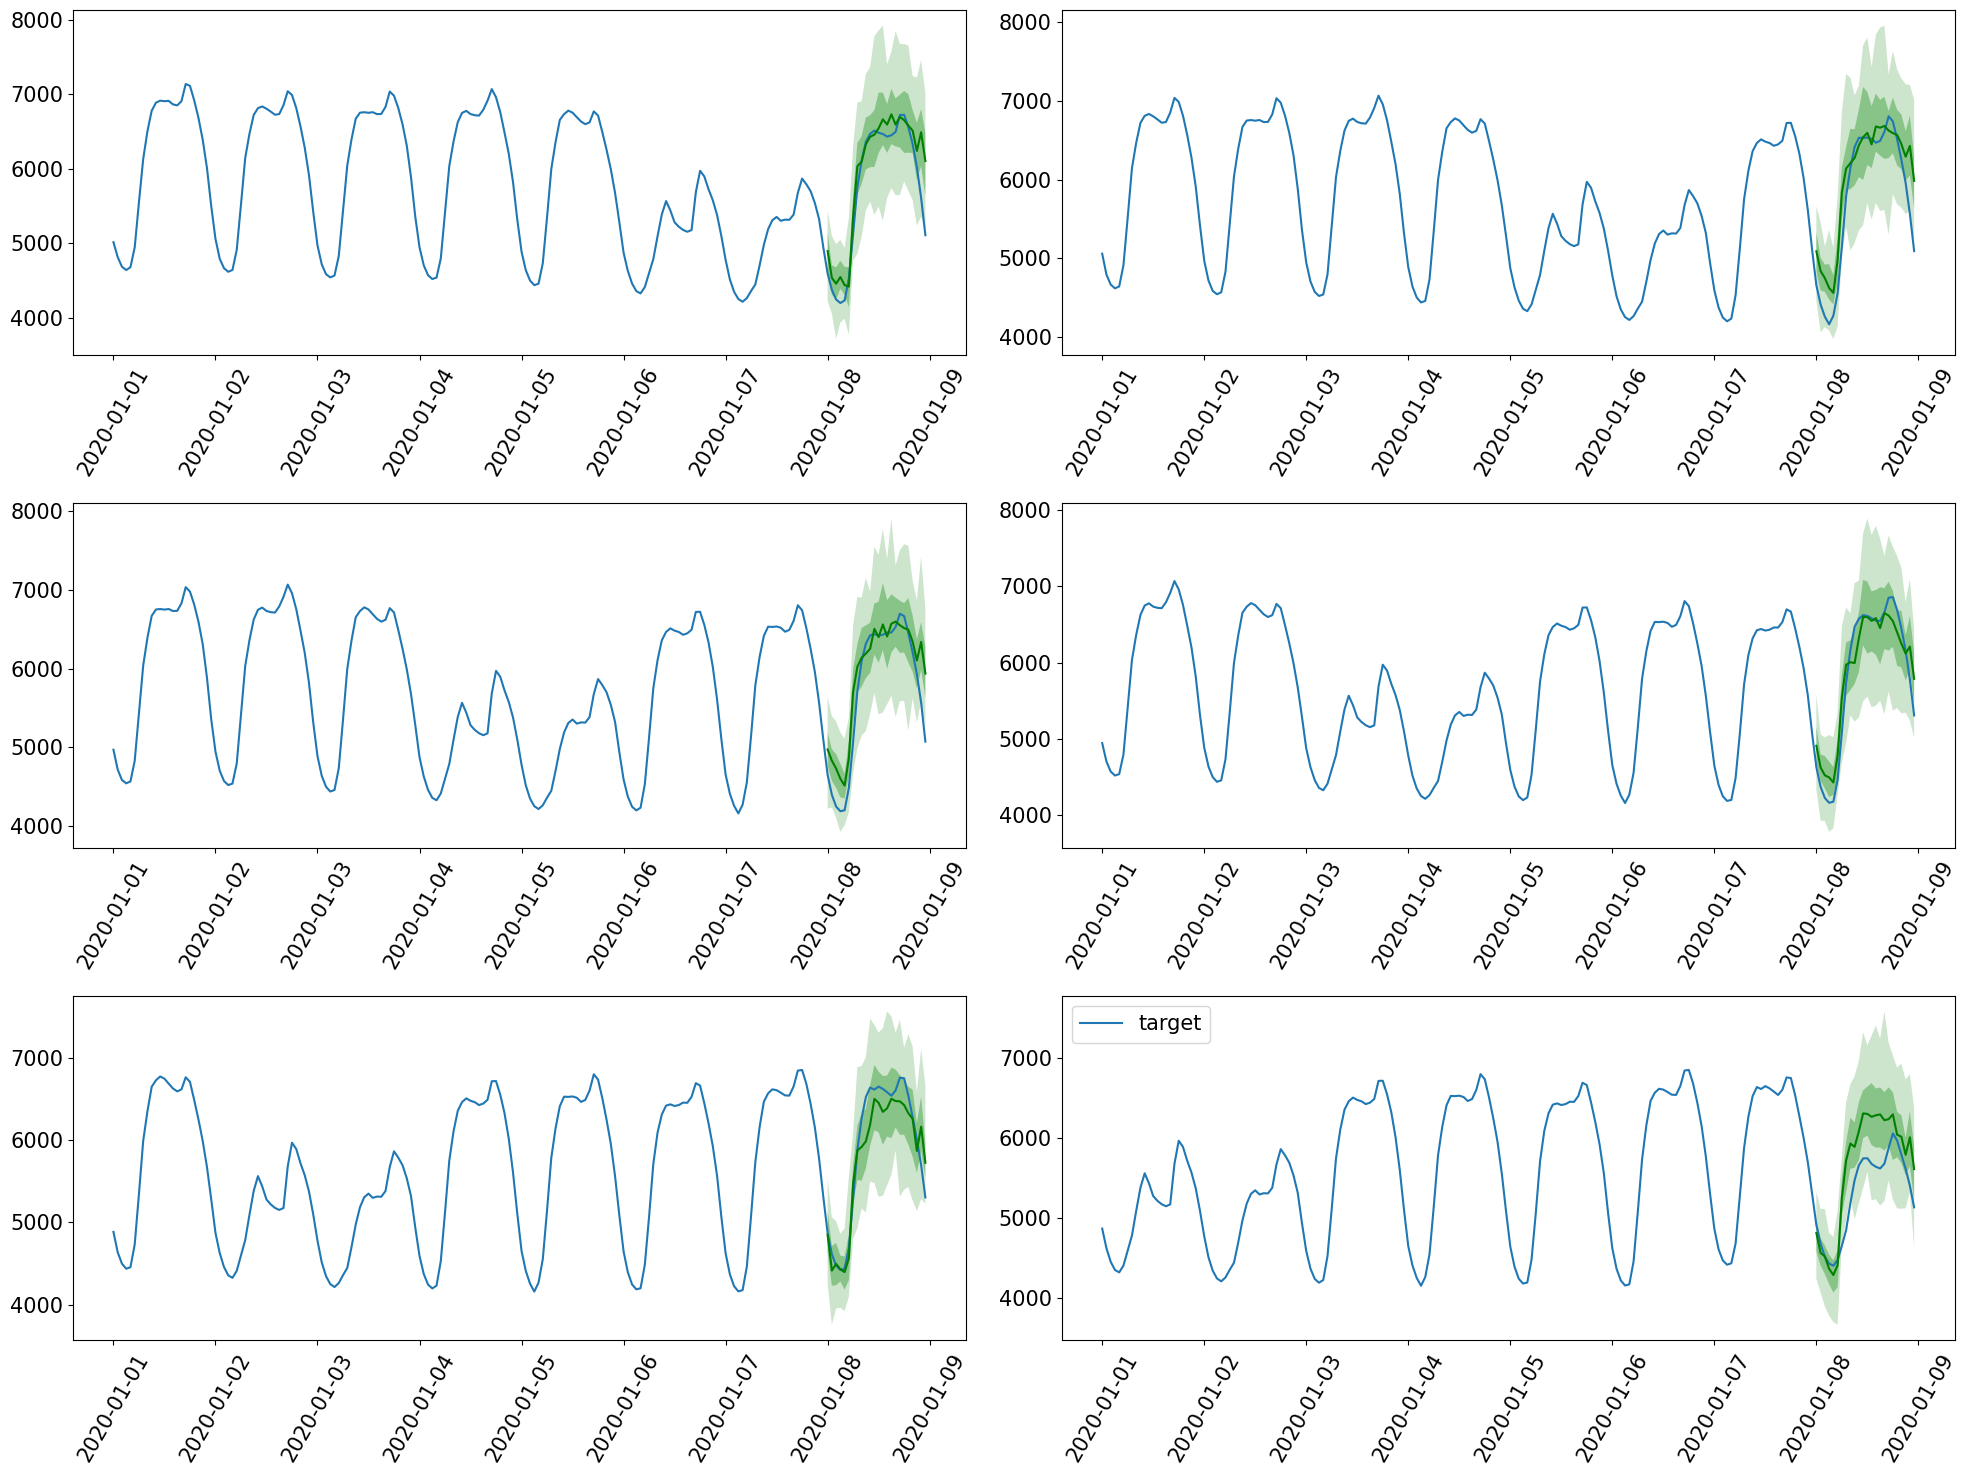

In [138]:
plt.figure(figsize=(20, 15))
# date_formater = mdates.DateFormatter('%Y, %m')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts_finetune, tss_finetune)), 6):
    ax = plt.subplot(3, 2, idx+1)
    plt.plot(ts.to_timestamp(), label="target")
    forecast.plot(color='g')

    plt.xticks(rotation=60)
    # ax.xaxis.set_major_formatter(date_formater)
    # ax.set_title(counties[idx])

plt.gcf().tight_layout()
plt.legend()
plt.show()

Ground truth:  38%|███▊      | 73/192 [00:00<00:00, 6381.63it/s]
Running evaluation: 73it [00:00, 1857.44it/s]
/home/hchuang/anaconda3/envs/lag-llama/lib/python3.10/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/hchuang/anaconda3/envs/lag-llama/lib/python3.10/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/hchuang/anaconda3/envs/lag-llama/lib/python3.10/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


6.296488387535697


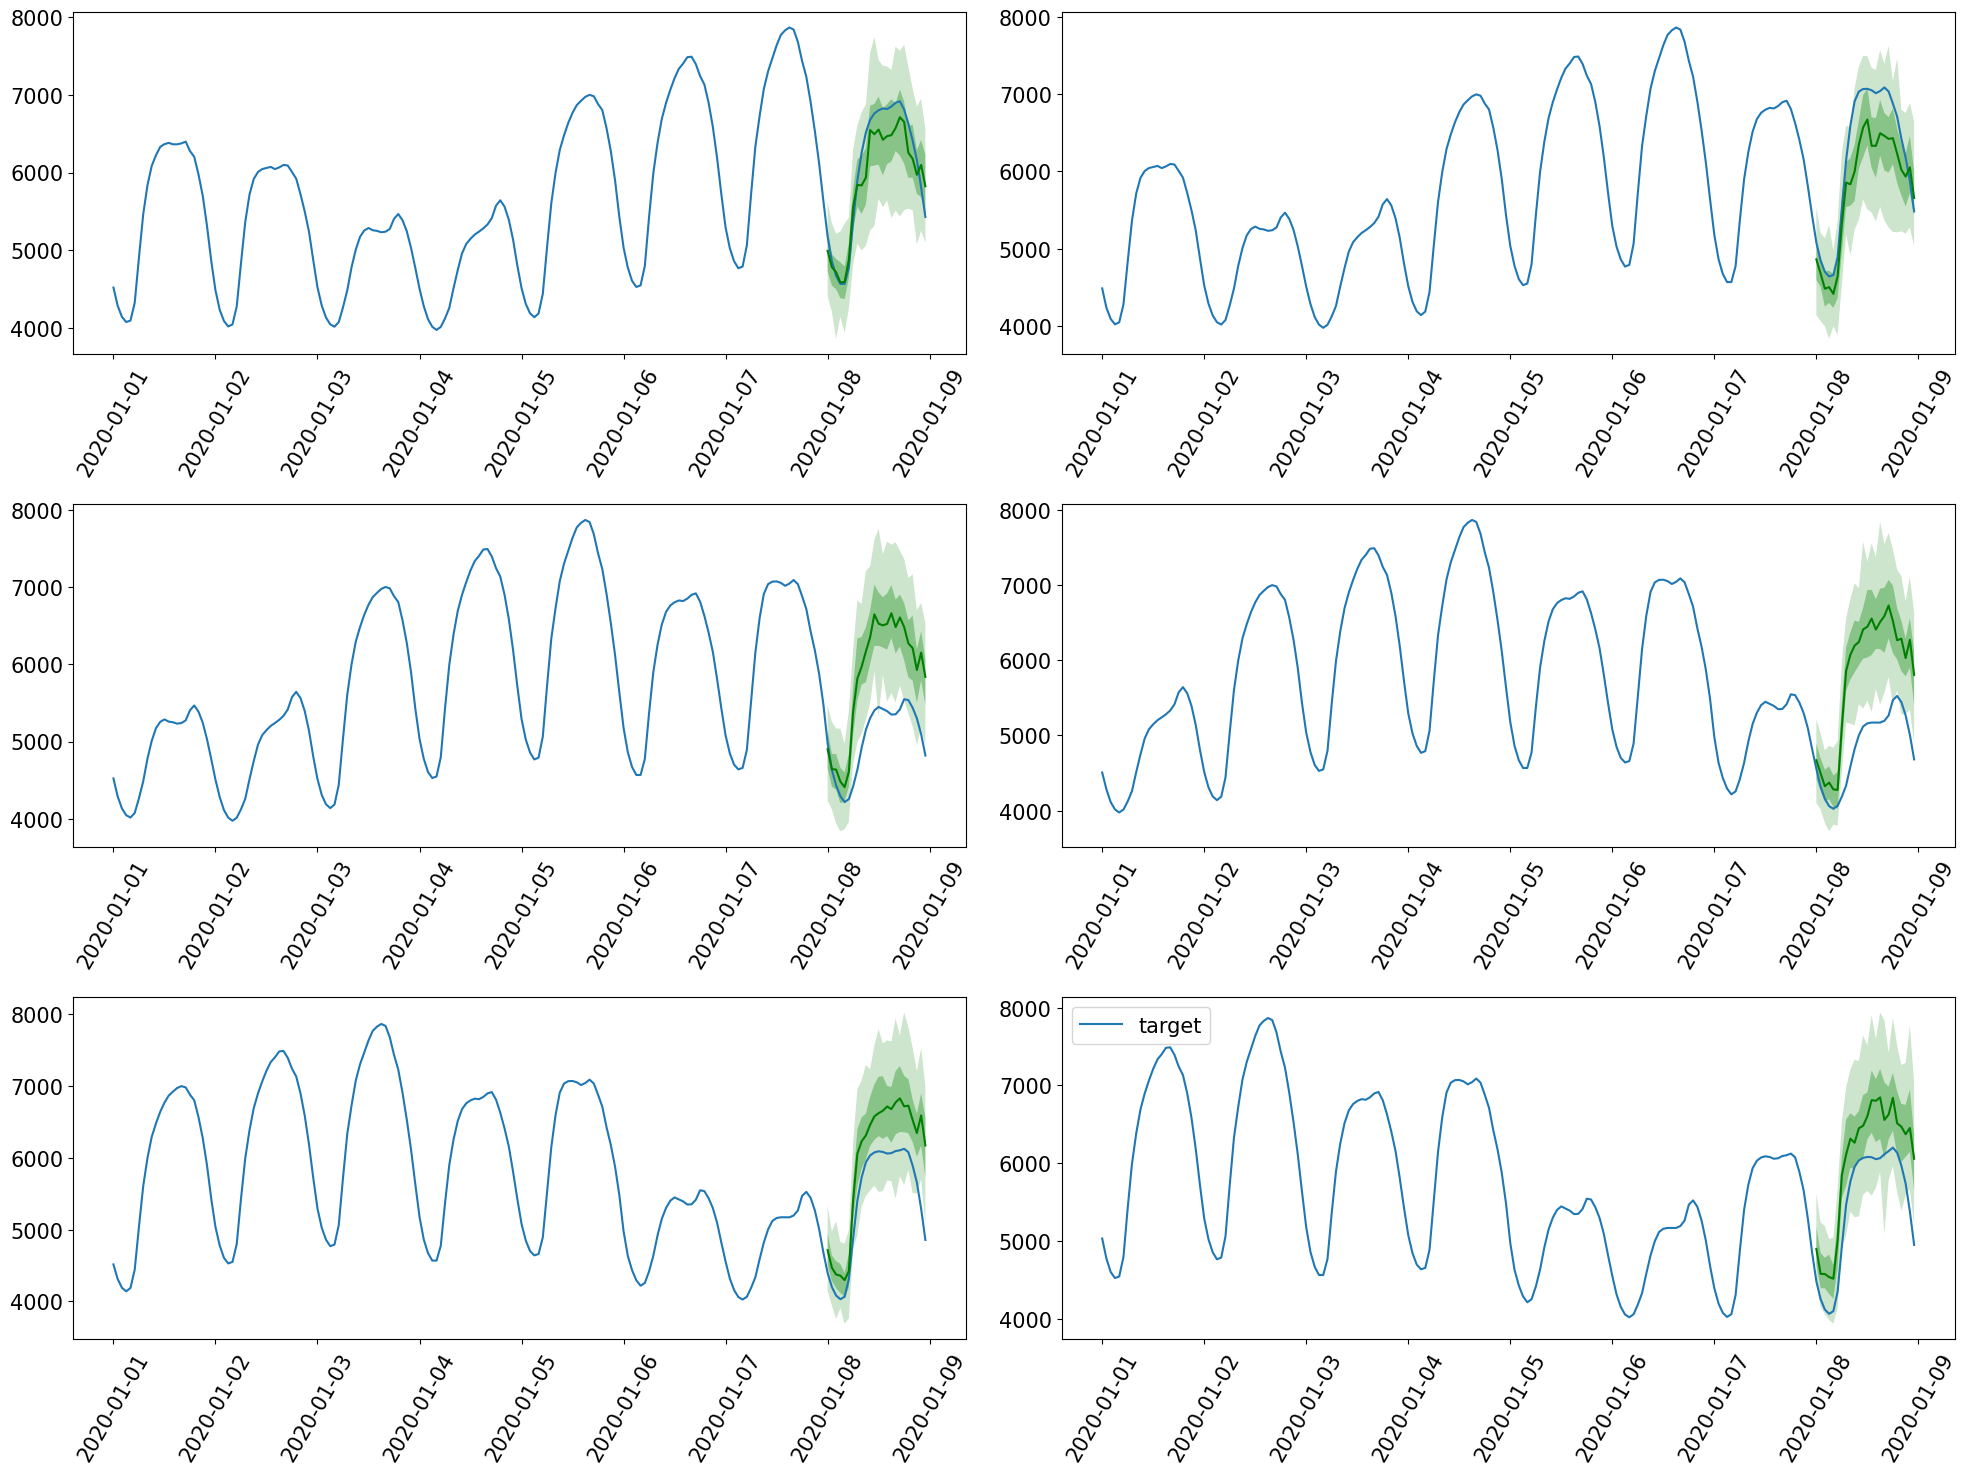

In [139]:
# test data
forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset_test,
        predictor=predictor,
        num_samples=num_samples
    )
from tqdm.autonotebook import tqdm

forecasts_finetune = list(tqdm(forecast_it, total=len(data_test), desc="Forecasting batches"))
# forecasts = [forecast for forecast in forecast_it]
tss_finetune = list(tqdm(ts_it, total=len(data_test), desc="Ground truth"))

# 評估微調後的表現
from gluonts.evaluation import make_evaluation_predictions, Evaluator
evaluator = Evaluator()
agg_metrics_finetune, ts_metrics_finetune = evaluator(iter(tss_finetune), iter(forecasts_finetune))
print(agg_metrics_finetune['MAPE']*100)

plt.figure(figsize=(20, 15))
# date_formater = mdates.DateFormatter('%Y, %m')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts_finetune, tss_finetune)), 6):
    ax = plt.subplot(3, 2, idx+1)
    plt.plot(ts.to_timestamp(), label="target")
    forecast.plot(color='g')

    plt.xticks(rotation=60)
    # ax.xaxis.set_major_formatter(date_formater)
    # ax.set_title(counties[idx])

plt.gcf().tight_layout()
plt.legend()
plt.show()

# Issue: DIFFERENT EPOCH

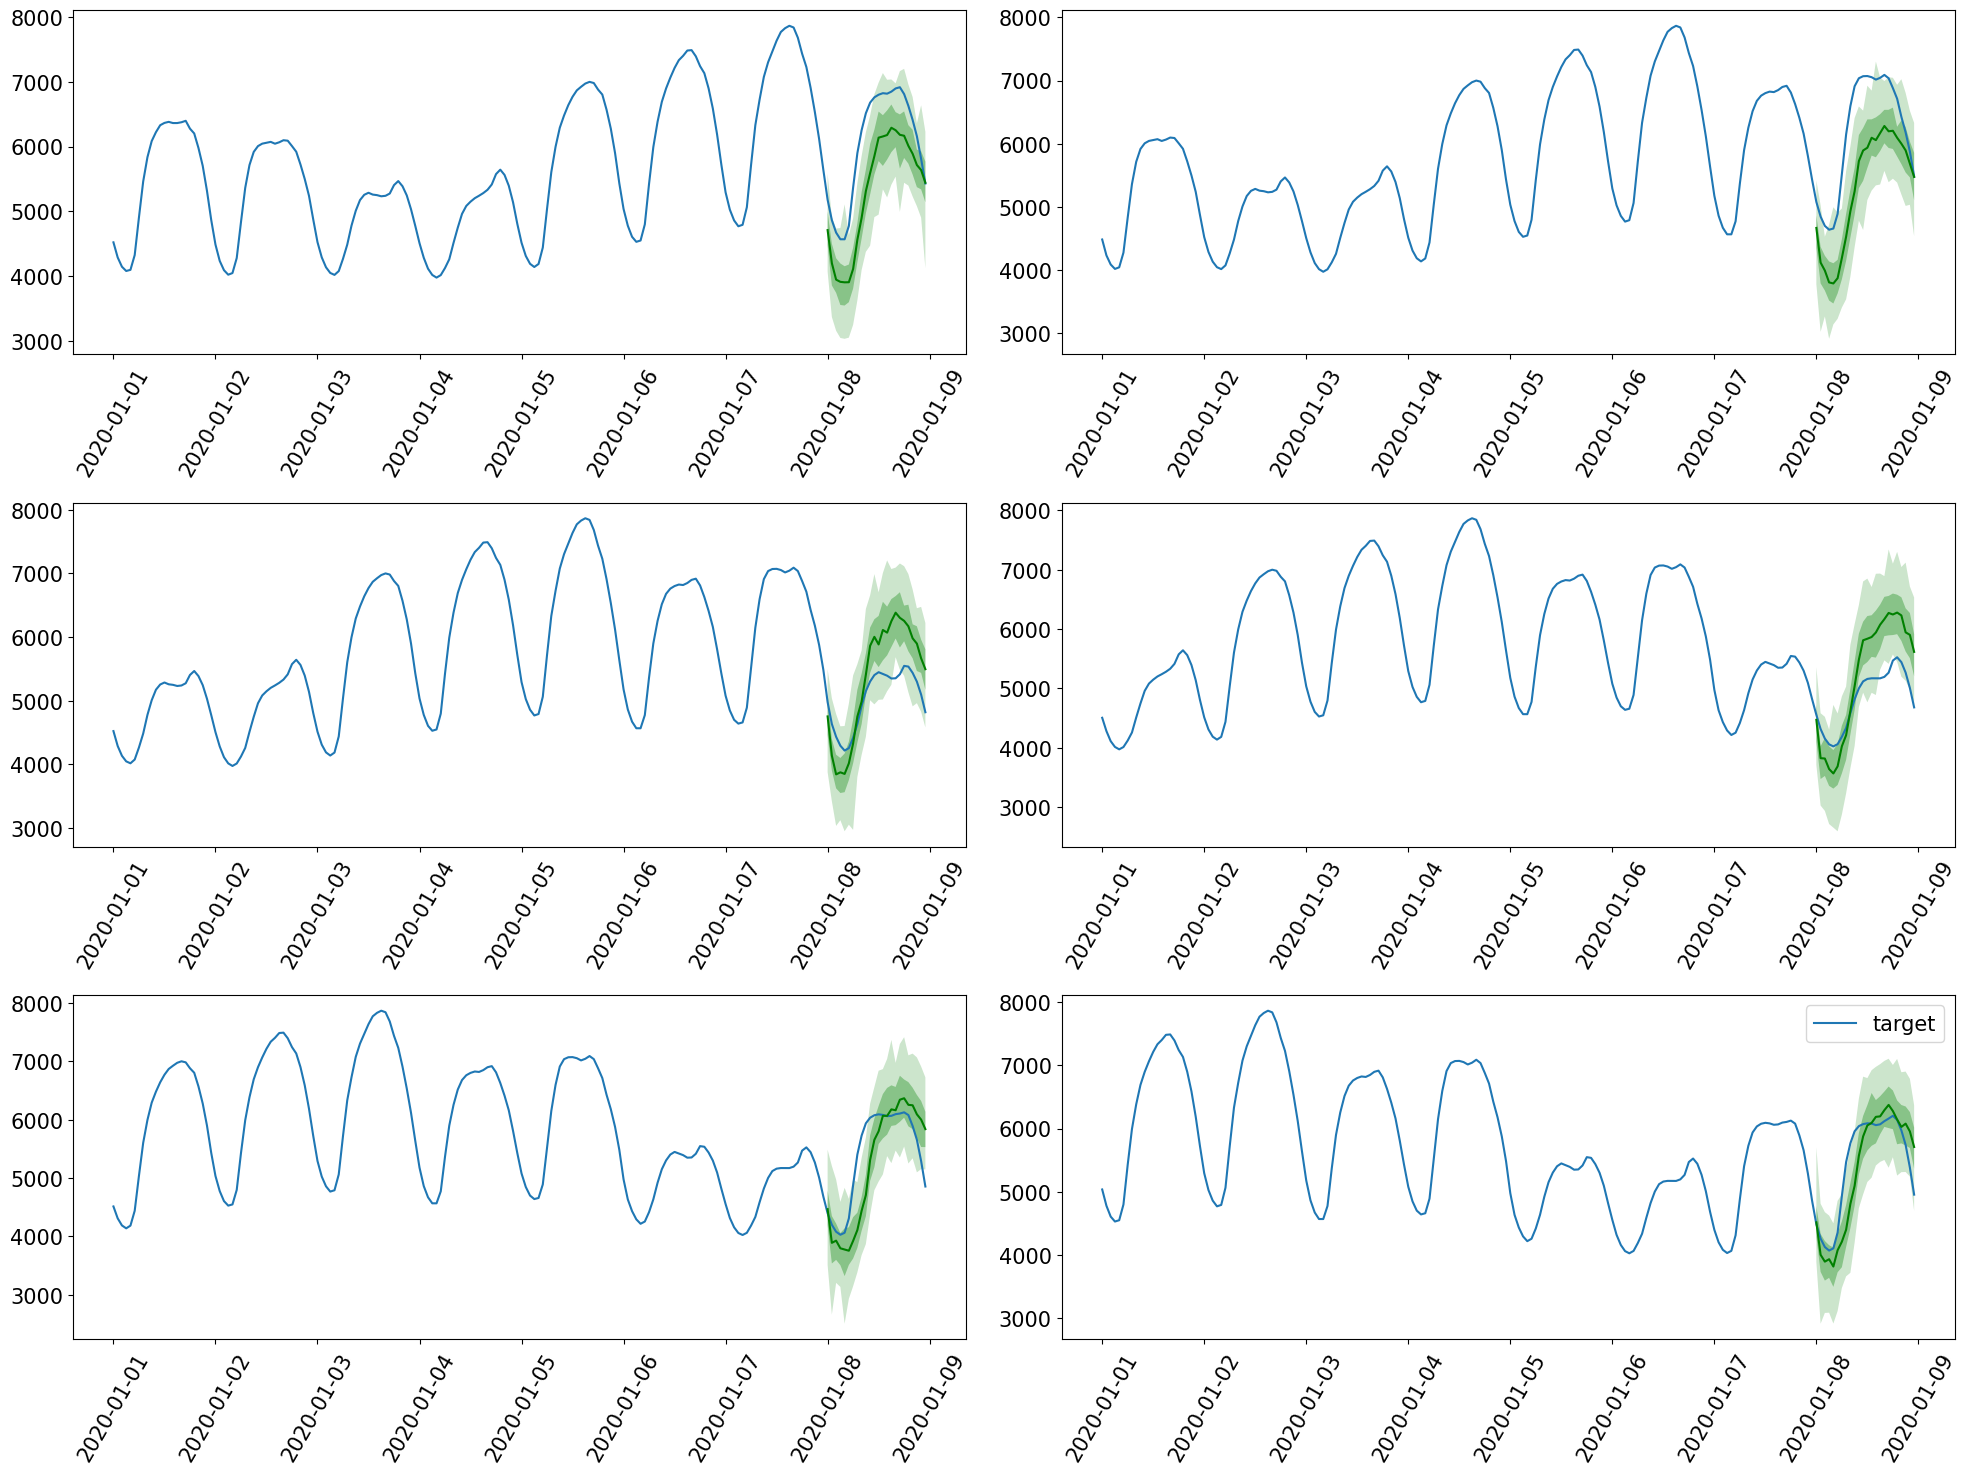

In [31]:
# 50 epoch
plt.figure(figsize=(20, 15))
# date_formater = mdates.DateFormatter('%Y, %m')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts_finetune, tss_finetune)), 6):
    ax = plt.subplot(3, 2, idx+1)
    plt.plot(ts.to_timestamp(), label="target")
    forecast.plot(color='g')

    plt.xticks(rotation=60)
    # ax.xaxis.set_major_formatter(date_formater)
    # ax.set_title(counties[idx])

plt.gcf().tight_layout()
plt.legend()
plt.show()

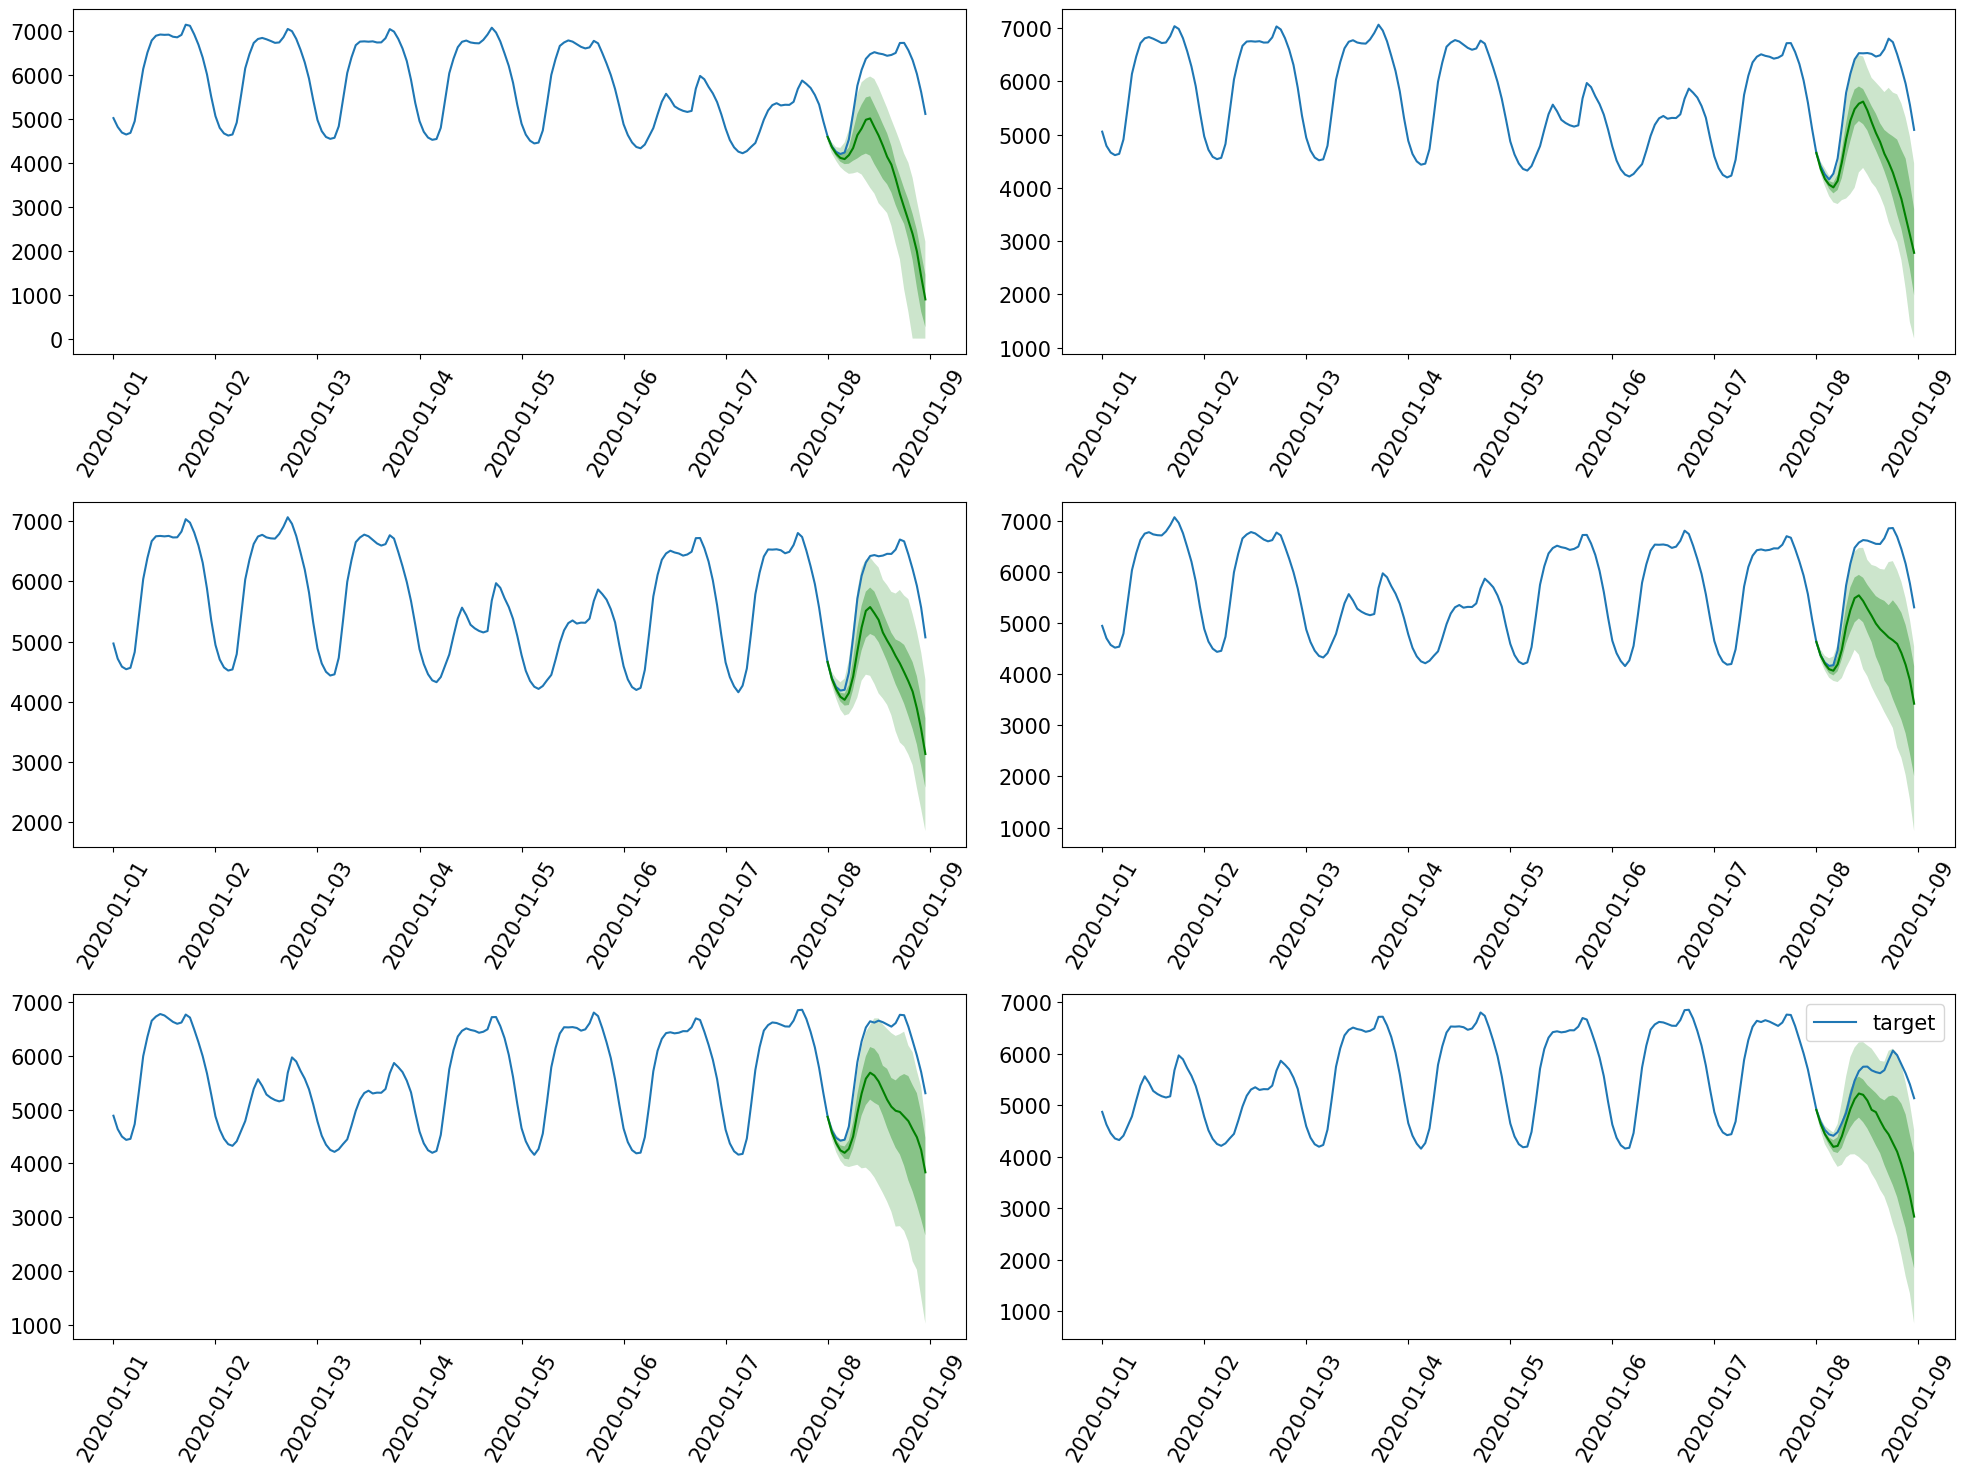

In [176]:
# 25 epoch
plt.figure(figsize=(20, 15))
# date_formater = mdates.DateFormatter('%Y, %m')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts_finetune, tss_finetune)), 6):
    ax = plt.subplot(3, 2, idx+1)
    plt.plot(ts.to_timestamp(), label="target")
    forecast.plot(color='g')

    plt.xticks(rotation=60)
    # ax.xaxis.set_major_formatter(date_formater)
    # ax.set_title(counties[idx])

plt.gcf().tight_layout()
plt.legend()
plt.show()

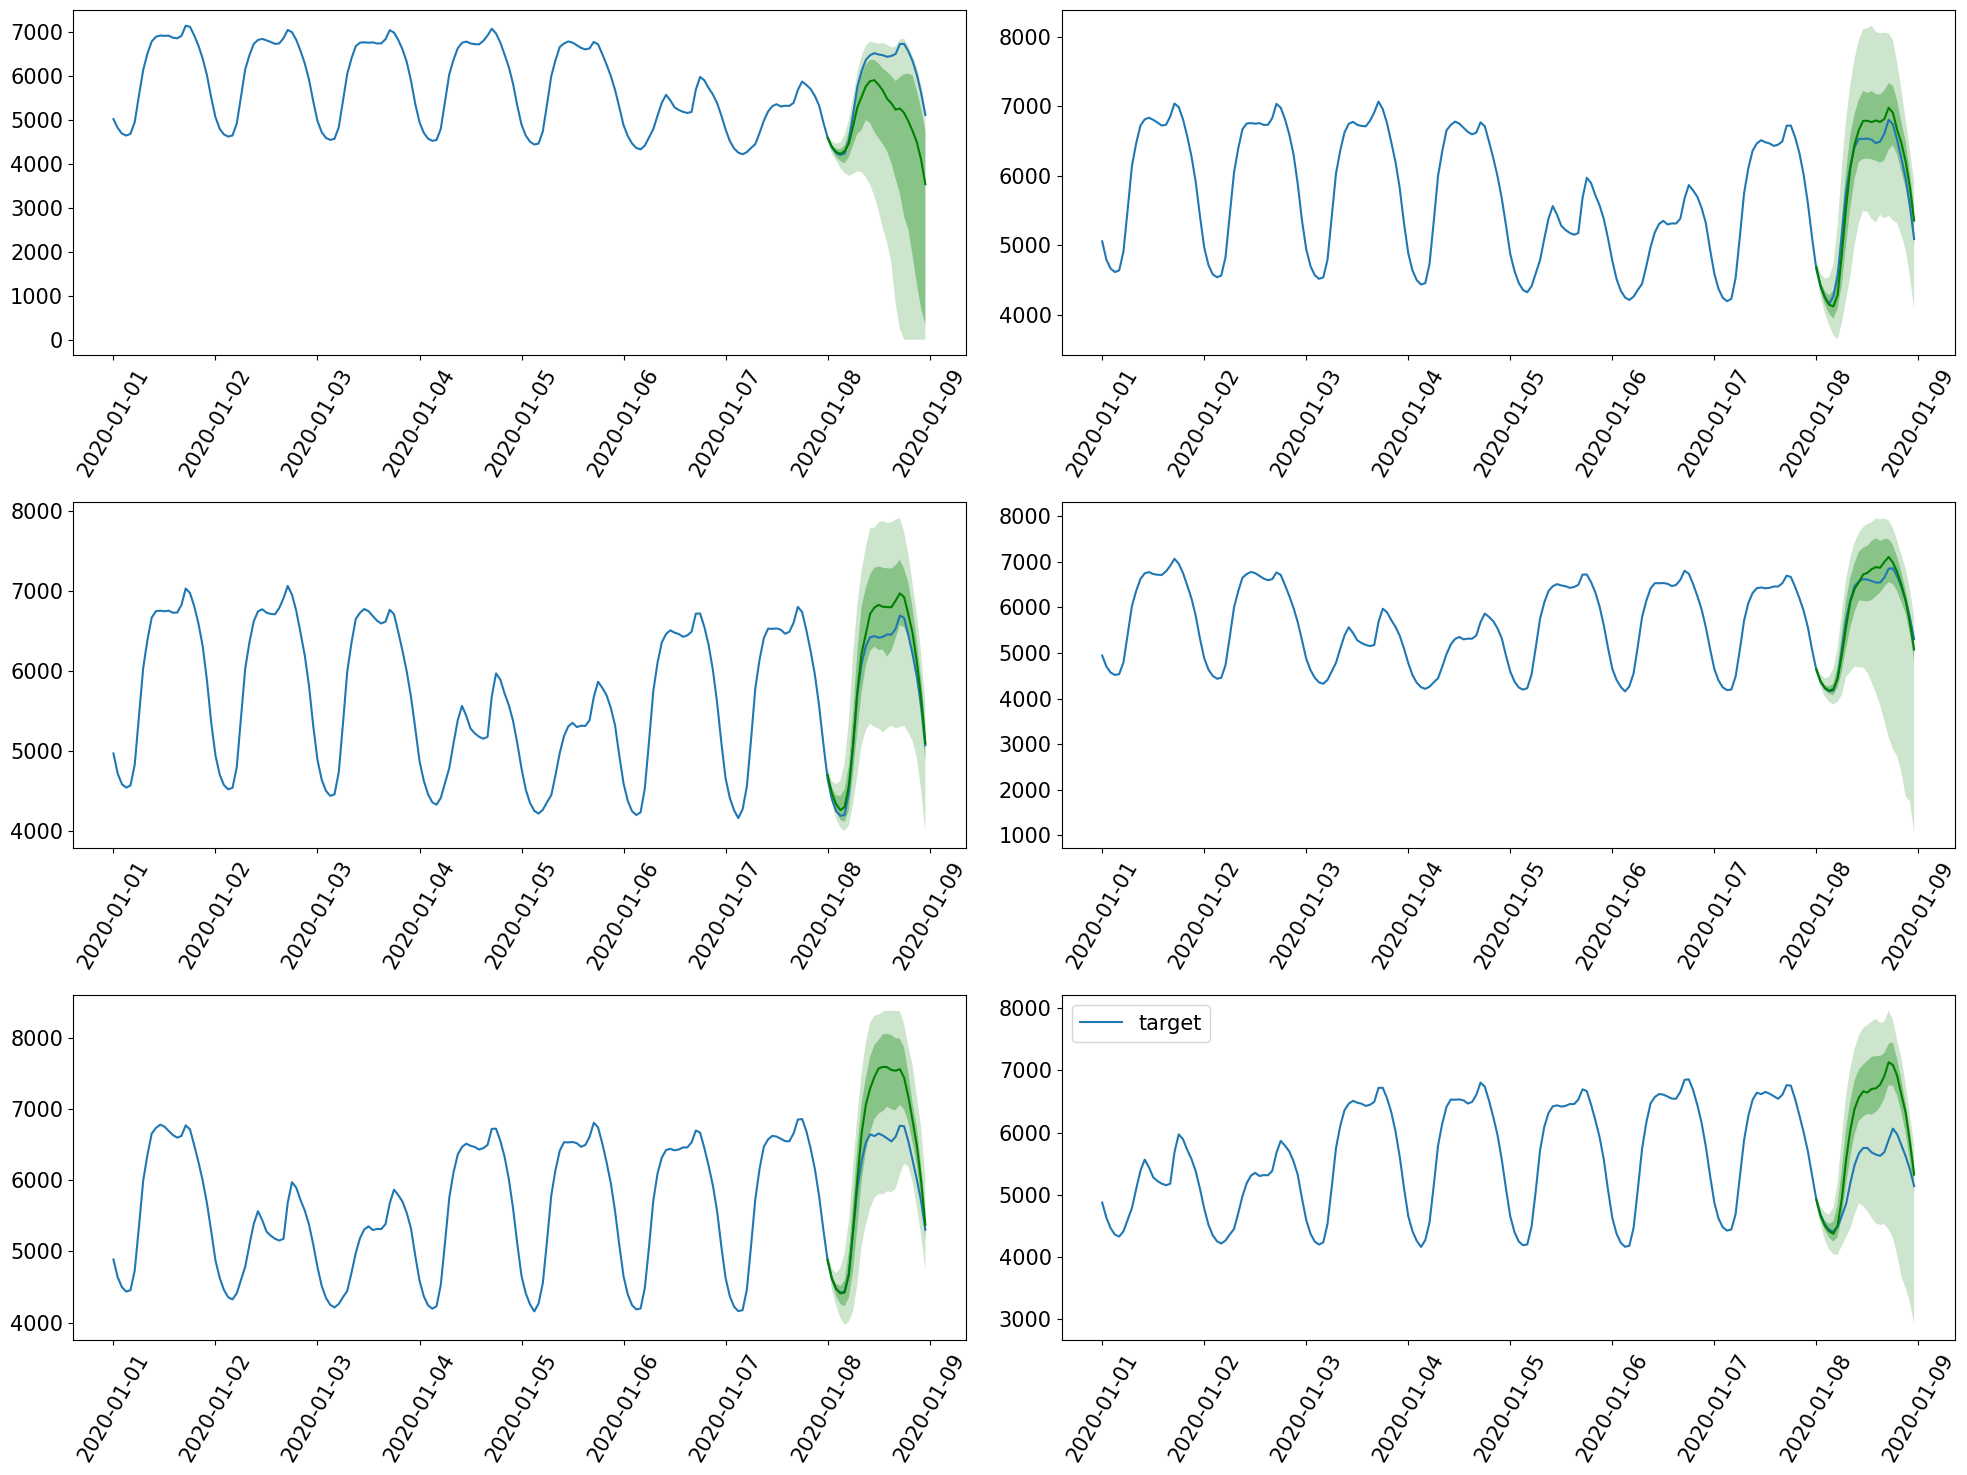

In [204]:
# 20 epoch
plt.figure(figsize=(20, 15))
# date_formater = mdates.DateFormatter('%Y, %m')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts_finetune, tss_finetune)), 6):
    ax = plt.subplot(3, 2, idx+1)
    plt.plot(ts.to_timestamp(), label="target")
    forecast.plot(color='g')

    plt.xticks(rotation=60)
    # ax.xaxis.set_major_formatter(date_formater)
    # ax.set_title(counties[idx])

plt.gcf().tight_layout()
plt.legend()
plt.show()

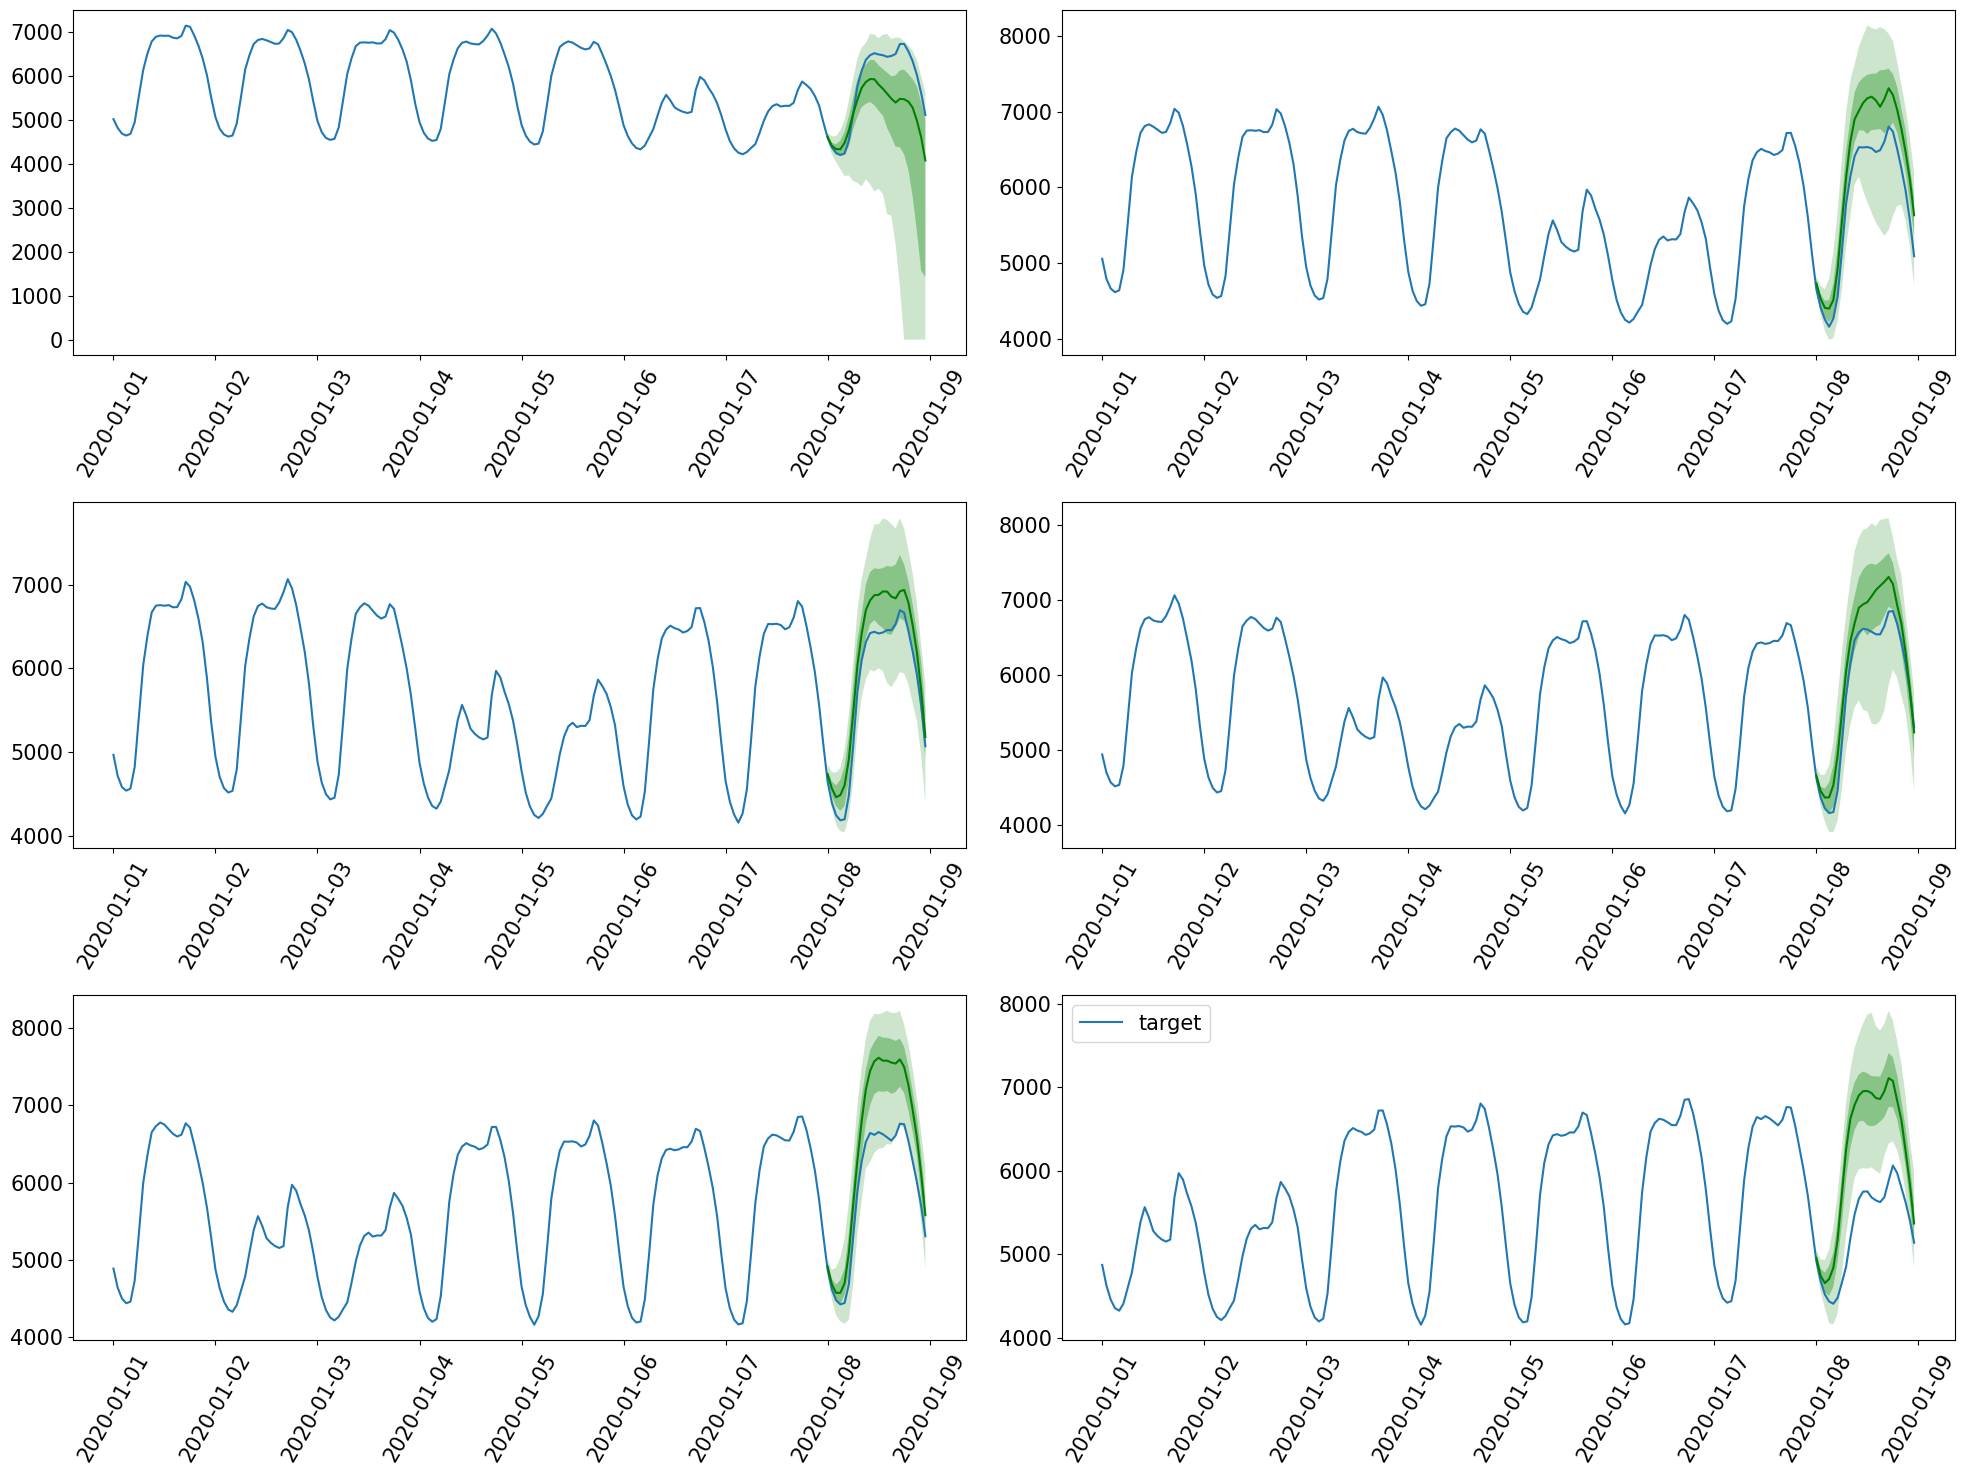

In [230]:
# 12 epoch
plt.figure(figsize=(20, 15))
# date_formater = mdates.DateFormatter('%Y, %m')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts_finetune, tss_finetune)), 6):
    ax = plt.subplot(3, 2, idx+1)
    plt.plot(ts.to_timestamp(), label="target")
    forecast.plot(color='g')

    plt.xticks(rotation=60)
    # ax.xaxis.set_major_formatter(date_formater)
    # ax.set_title(counties[idx])

plt.gcf().tight_layout()
plt.legend()
plt.show()

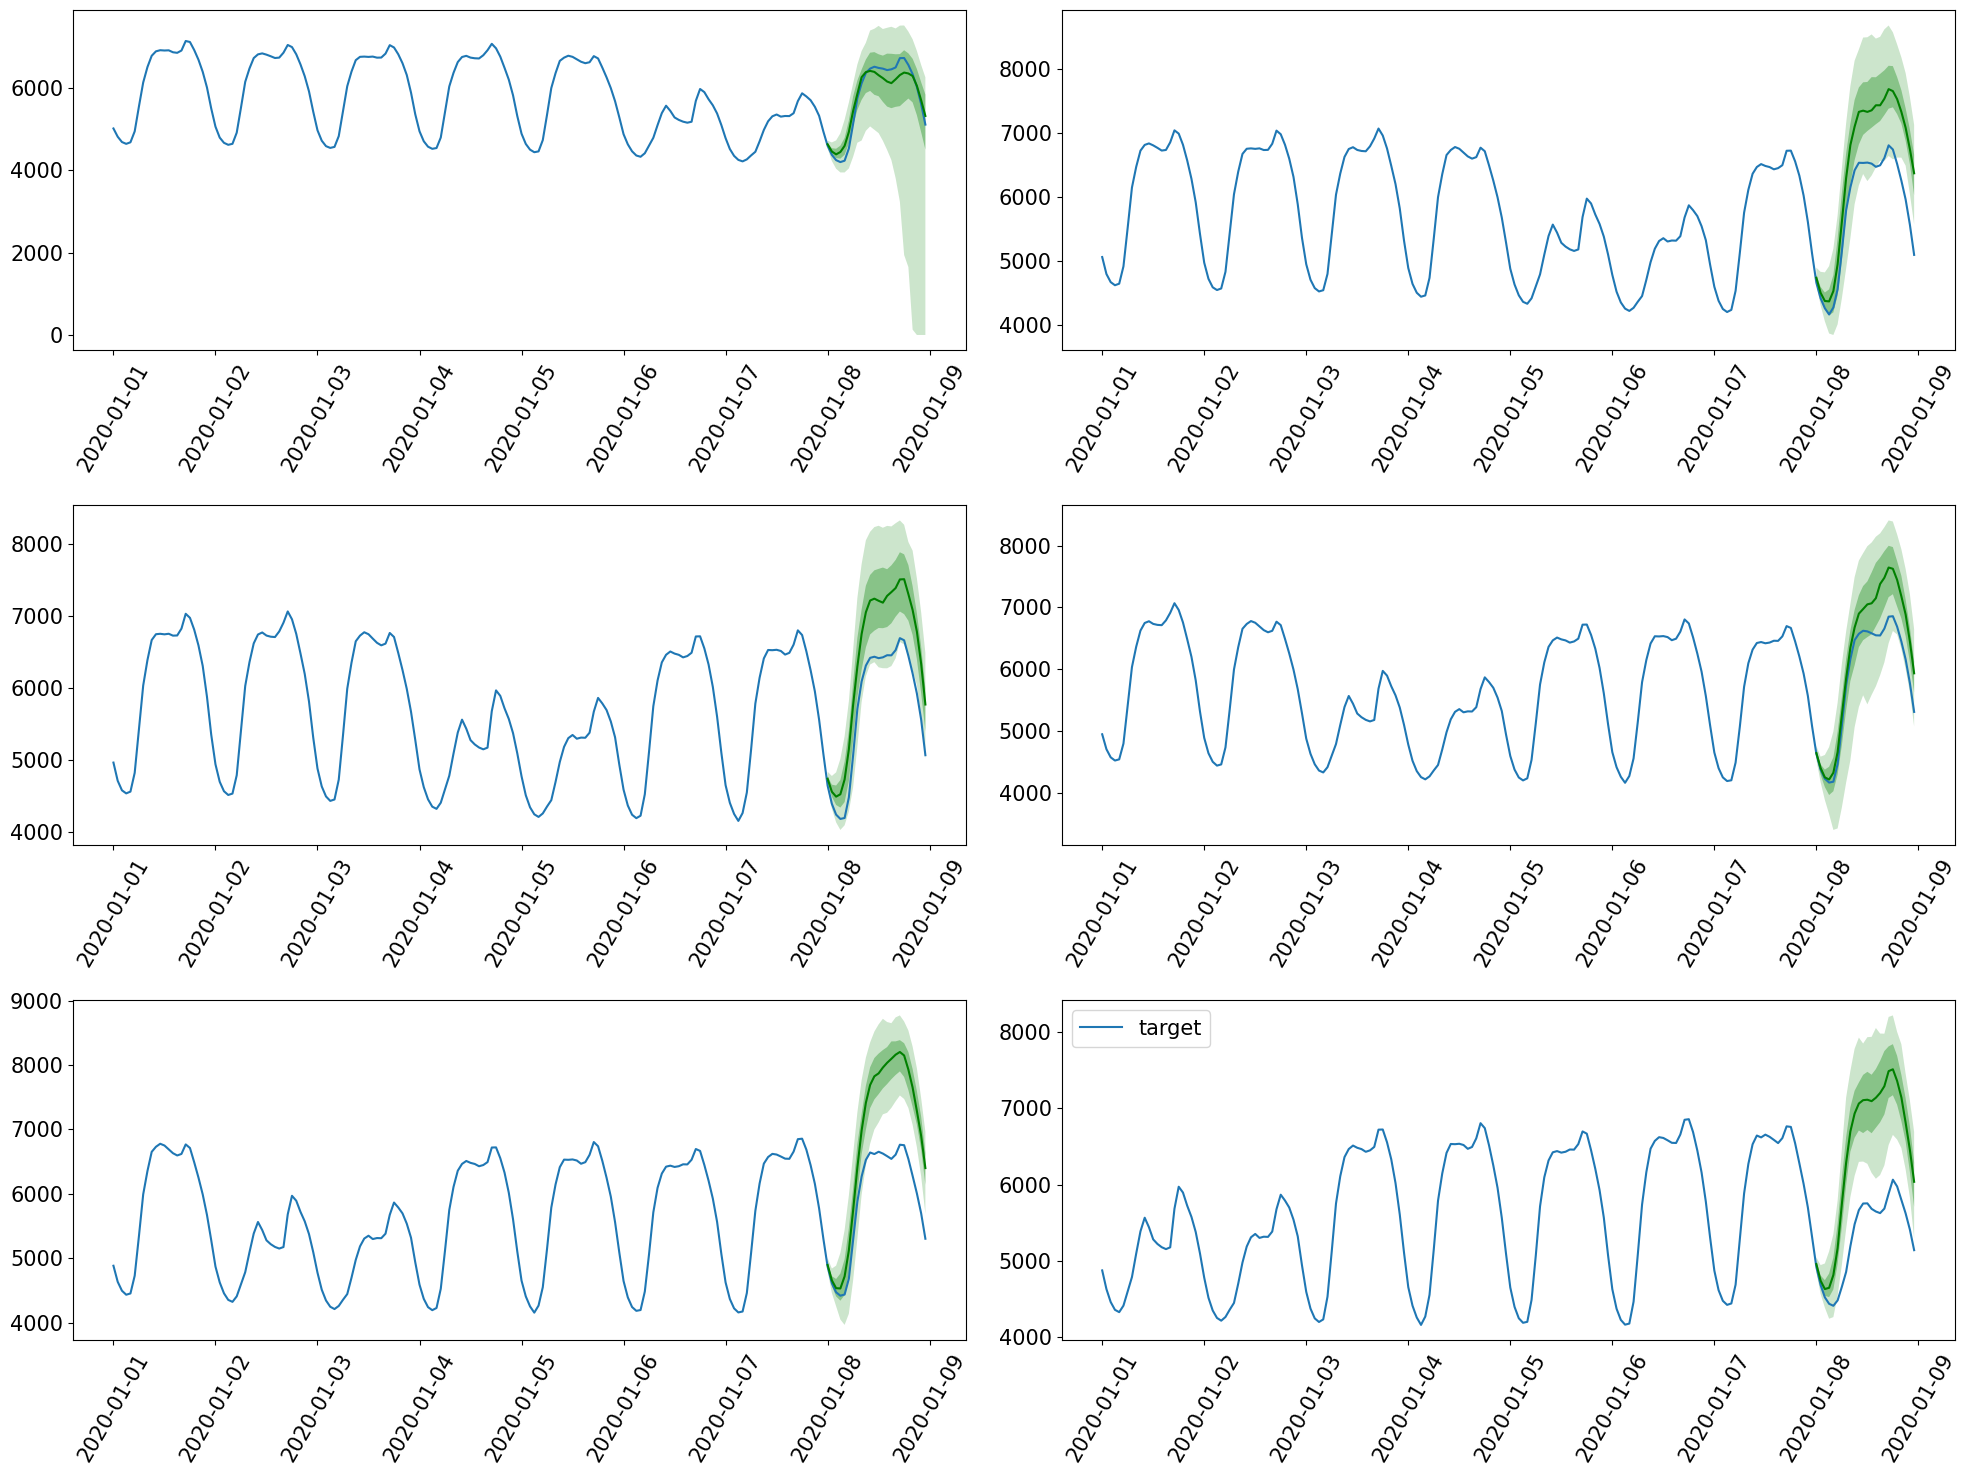

In [223]:
# 10 epoch
plt.figure(figsize=(20, 15))
# date_formater = mdates.DateFormatter('%Y, %m')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts_finetune, tss_finetune)), 6):
    ax = plt.subplot(3, 2, idx+1)
    plt.plot(ts.to_timestamp(), label="target")
    forecast.plot(color='g')

    plt.xticks(rotation=60)
    # ax.xaxis.set_major_formatter(date_formater)
    # ax.set_title(counties[idx])

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [ ]:
for obs in range(10):
    x = range(0,192)
    y = train_nyc_npy[obs,:]
    x_pred = range(168, 192)
    y_pred = pred[obs,:]


    plt.figure(figsize=(12, 4)) 
    plt.plot(x, y, color = 'tab:gray')
    plt.plot(x_pred, y_pred, color = 'tab:blue')
    #plt.title(f'{zone_name[zone_index]}: MAPE = {round(mape_all[obs],2)} , MSE = {round(mse_all[obs]*1,2)}')
    plt.xticks(rotation=45) 
    plt.show()

# Load fine-tuned model

In [147]:
def get_lag_llama_predictions(dataset, prediction_length, device, context_length=32, use_rope_scaling=False, num_samples=100):
    ckpt = torch.load("/home/hchuang/Documents/Project/lag-llama/lightning_logs/version_7/checkpoints/epoch=14-step=750.ckpt", map_location=device, weights_only = False) # Uses GPU since in this Colab we use a GPU.
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length, # Lag-Llama was trained with a context length of 32, but can work with any context length

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,

        batch_size=1,
        num_parallel_samples=100,
        device=device,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

In [150]:
test_nyc_npy = np.squeeze(data_dict['N.Y.C._test.npy']) # reduce useless dimension ((73, 92, 1) -> (73, 92))
df_wide = pd.DataFrame(test_nyc_npy).T # (192,73)

# Pre-process

# (new)Generate a DatetimeIndex for PandasDataset(dict(df_wide))
dt_index = pd.date_range(start="2024-01-01", periods=192, freq="D")
df_wide.index = dt_index

# Convert numerical columns to float 32 format for lag-llama
for col in df_wide.columns:
    # Check if column is not of string type
    if df_wide[col].dtype != 'object' and pd.api.types.is_string_dtype(df_wide[col]) == False:
        df_wide[col] = df_wide[col].astype('float32')

# Create a PandasDataset
ds = PandasDataset(dict(df_wide))

# Prediction

backtest_dataset = ds
prediction_length = 24  # Define your prediction length (e.g., 24 here since the data frequency is hourly).
num_samples = 100 # number of samples sampled from the probability distribution for each timestep
device = torch.device("cuda:0") # You can switch this to CPU or other GPUs if you'd like, depending on your environment


forecasts, tss = get_lag_llama_predictions(backtest_dataset, prediction_length, device, num_samples = num_samples) # (new) note that num_samples is optional argu, need to specify

d = forecasts[0].samples
d.shape

(100, 24)

In [151]:
# Evaluation
actual = test_nyc_npy[:,-24:]
pred = np.array([np.mean(forecasts[i].samples,axis=0) for i in range(len(forecasts))])

mape = np.mean(abs((pred - actual)/actual))*100

print(f"MAPE: {round(mape,4)}")


MAPE: 20.1388


In [152]:
forecasts = list(tqdm(forecasts, total=len(data_test), desc="Forecasting batches"))
# forecasts = [forecast for forecast in forecast_it]
tss  = list(tqdm(tss, total=len(data_test), desc="Ground truth"))

# 評估微調後的表現
from gluonts.evaluation import make_evaluation_predictions, Evaluator
evaluator = Evaluator()
agg_metrics_finetune, ts_metrics_finetune = evaluator(iter(tss), iter(forecasts))
print(agg_metrics_finetune['MAPE']*100)

Ground truth:  38%|███▊      | 73/192 [00:00<00:00, 564915.48it/s]
Running evaluation: 73it [00:00, 1253.39it/s]
/home/hchuang/anaconda3/envs/lag-llama/lib/python3.10/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/hchuang/anaconda3/envs/lag-llama/lib/python3.10/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/hchuang/anaconda3/envs/lag-llama/lib/python3.10/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


17.345141275832642
